### Installing Dependencies and Importing them

In [ ]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
pip install tensorflow==2.10.1

In [1]:
import os
import cv2 as cv
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-07-17 13:40:51.496132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 13:40:51.496264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 13:40:51.623239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### To use our GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU:", physical_devices[0])
except:
    pass


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def load_video(path:str) -> List[float]:
    cap = cv.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:230,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
        
        # Standard normalization (or standardization) transforms
        #data such that it has a mean of zero and a standard deviation of one.
    return tf.cast((frames-mean), tf.float32)/ std       

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!0123456789 "]


In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =41)


In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, " ", line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), shape=[-1]))
      

In [8]:
tf.version

<module 'tensorflow._api.v2.version' from '/opt/conda/lib/python3.10/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [9]:
def load_data(path:str):
    path  = bytes.decode(path.numpy())
    
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join("/kaggle/input/lipreading/data/",'s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/kaggle/input/lipreading/data/','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [10]:
test_path = '/kaggle/input/lipnet/LipNet/s1/bbaz4n.mpg'

In [11]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [12]:
frames.shape

TensorShape([75, 40, 140, 1])

In [13]:
alignments.shape

TensorShape([23])

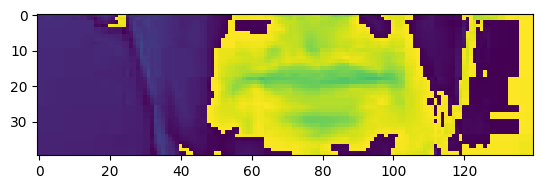

In [14]:
plt.imshow(frames[0])

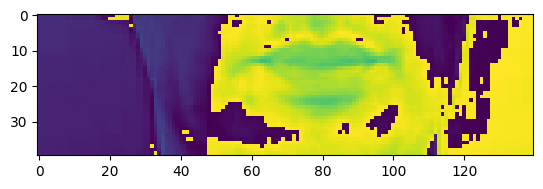

In [15]:
plt.imshow(frames[25])

In [16]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at z four now'>

In [17]:
def mappable_function(path:str) -> List[str]:     # tensorflow piple requires us to use this py_function
    result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

### Creating Data Pipeline

In [60]:
#data = tf.data.Dataset.list_files("/kaggle/input/lipnet/LipNet/s1*.mpg")
data = tf.data.Dataset.list_files("/kaggle/input/lipreading/data/s1/*.mpg")

data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))    # lenght of each alignmets is going to be diffrent so we have padded it to make its lengh same for all 
data = data.prefetch(tf.data.AUTOTUNE)    # prefetchs data batches asynchronously during model training

train = data.take(450)
test = data.skip(450)

In [61]:
len(test)

50

In [62]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [63]:
len(data)

500

In [64]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
len(frames)   ## now we have 2 videos in each batch

2

In [25]:
test = data.as_numpy_iterator()

In [26]:
val = test.next(); val[0]

array([[[[[1.2419279 ],
          [1.2419279 ],
          [1.2419279 ],
          ...,
          [8.806397  ],
          [9.295642  ],
          [9.220373  ]],

         [[1.2419279 ],
          [1.2419279 ],
          [1.2419279 ],
          ...,
          [8.580592  ],
          [8.693495  ],
          [8.354787  ]],

         [[1.2419279 ],
          [1.2419279 ],
          [1.2419279 ],
          ...,
          [8.956934  ],
          [9.145105  ],
          [9.182739  ]],

         ...,

         [[0.90322024],
          [0.90322024],
          [0.90322024],
          ...,
          [9.483812  ],
          [9.521446  ],
          [9.521446  ]],

         [[0.90322024],
          [0.90322024],
          [0.90322024],
          ...,
          [9.521446  ],
          [9.521446  ],
          [9.521446  ]],

         [[0.90322024],
          [0.90322024],
          [0.90322024],
          ...,
          [9.521446  ],
          [9.521446  ],
          [9.521446  ]]],


        [[[1.2419

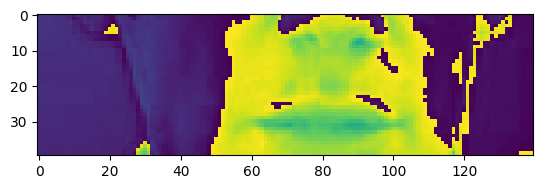

In [27]:
plt.imshow(val[0][1][24])

In [28]:
len(val[0][1])
print(val[0][1])

[[[[1.479578  ]
   [1.479578  ]
   [1.4425886 ]
   ...
   [0.33290505]
   [0.33290505]
   [0.33290505]]

  [[1.4055991 ]
   [1.4055991 ]
   [1.3686097 ]
   ...
   [0.33290505]
   [0.33290505]
   [0.33290505]]

  [[1.4055991 ]
   [1.4055991 ]
   [1.3316202 ]
   ...
   [0.3698945 ]
   [0.25892615]
   [0.25892615]]

  ...

  [[1.0726941 ]
   [1.0726941 ]
   [1.0726941 ]
   ...
   [0.03698945]
   [0.03698945]
   [0.        ]]

  [[1.0726941 ]
   [1.0726941 ]
   [1.0726941 ]
   ...
   [0.03698945]
   [0.        ]
   [0.        ]]

  [[1.0726941 ]
   [1.0726941 ]
   [1.0726941 ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[1.5165675 ]
   [1.479578  ]
   [1.4055991 ]
   ...
   [0.2219367 ]
   [0.18494725]
   [0.18494725]]

  [[1.479578  ]
   [1.4055991 ]
   [1.3316202 ]
   ...
   [0.2219367 ]
   [0.18494725]
   [0.18494725]]

  [[1.3686097 ]
   [1.3686097 ]
   [1.4055991 ]
   ...
   [0.33290505]
   [0.2219367 ]
   [0.2219367 ]]

  ...

  [[1.0357046 ]
   [1.0357046 ]
   [1.0

In [29]:
import os

directory = '/kaggle/working/animations'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")


Directory '/kaggle/working/animations' created successfully.


In [30]:
import numpy as np
import imageio

video_frames = val[0][1]

# Ensure frames are in the correct shape and format for an animation
video_frames = np.squeeze(video_frames)

num_frames, height, width = video_frames.shape
video_frames_uint8 = (video_frames * 255).astype(np.uint8)
video_frames_reshaped = np.reshape(video_frames_uint8, (num_frames, height, width))

output_path = "/kaggle/working/animations/animation.gif"
imageio.mimsave('/kaggle/working/animations/animation.gif', video_frames_reshaped, fps=10)

print(f"Animation saved successfully to: {output_path}")


Animation saved successfully to: /kaggle/working/animations/animation.gif


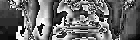

In [31]:
from IPython.display import Image

# Specify the path to your saved GIF
gif_path = '/kaggle/working/animations/animation.gif'

# Display the GIF
Image(filename=gif_path, width=400, height=300 , )


In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b' lay green by m two now'>

### Designing the Deep Neural Netwok


In [33]:
# pip install --upgrade tensorflow 
#  run this cell just in case 

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 40, 140, 1)

In [36]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [37]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), input_shape=(75, 40, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


# model.add(TimeDistributed(Flatten()))
model.add(Reshape(( 75, -1)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer="he_normal", activation="softmax"))

# model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer="he_normal", activation="softmax"))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 40, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 40, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 20, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 20, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 20, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 10, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 10, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 10, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 42)         │        10,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,472,181 (32.32 MB)

 Trainable params: 8,472,181 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'hhhhhhhhhhhhhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss1'>

In [41]:
model.input_shape

(None, 75, 40, 140, 1)

In [42]:
model.output_shape

(None, 75, 42)

###  Seting up Traing options and Train the Model

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss
    
    

In [71]:
class produce_example(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))




# class ProduceExampleCallback(tf.keras.callbacks.Callback):
#     def __init__(self, dataset):
#         super(ProduceExampleCallback, self).__init__()
#         self.dataset = dataset  # Assuming `dataset` is a TensorFlow dataset object

#     def on_epoch_end(self, epoch, logs=None):
#         # Get a batch of data from the dataset
#         data = next(iter(self.dataset.batch(1)))

#         inputs, targets = data[0], data[1]

#         # Make predictions using the model
#         predictions = self.model.predict(inputs)

#         # Decode predictions and targets to text
#         decoded_targets = tf.strings.reduce_join([vocab[word] + " " for word in targets[0]]).numpy().decode('utf-8')
#         decoded_predictions = tf.strings.reduce_join([vocab[word] + " " for word in predictions[0]]).numpy().decode('utf-8')

#         # Print original and predicted text
#         print(f"Original: {decoded_targets}")
#         print(f"Prediction: {decoded_predictions}")
#         print("-" * 50)


In [72]:
#from tensorflow.keras.optimizers.legacy import Adam

In [73]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTC_loss)

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [48]:
!rm Models

rm: cannot remove 'Models': No such file or directory


In [49]:
!mkdir models

In [50]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [51]:
schedule_callback = LearningRateScheduler(scheduler)

In [52]:
test

In [53]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [54]:
test

In [57]:
example_callback = produce_example(test)


In [58]:
checkpoint_path = '/kaggle/working/models/checkpoint.weights.h5'
model.load_weights(checkpoint_path)

# Optionally, print model summary to inspect the loaded model architecture
model.summary()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/models/checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Model training Done

In [ ]:
#Model trained to 60 epoches 
model.fit(train,validation_data = test, epochs=29, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/29
 43/450 ━━━━━━━━━━━━━━━━━━━━ 4:33 673ms/step - loss: 73.0594

[mpeg1video @ 0x7a3c1403c040] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c1403c040] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - loss: 71.5778

[mpeg1video @ 0x7a3aae5c8ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3aae5c8ec0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - loss: 71.5751 - val_loss: 64.9284 - learning_rate: 1.0000e-04
Epoch 2/29
313/450 ━━━━━━━━━━━━━━━━━━━━ 1:31 668ms/step - loss: 67.6460

[mpeg1video @ 0x7a3d705af040] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3d705af040] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - loss: 67.4483

[mpeg1video @ 0x5d4011410fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x5d4011410fc0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - loss: 67.4467 - val_loss: 61.7924 - learning_rate: 1.0000e-04
Epoch 3/29
224/450 ━━━━━━━━━━━━━━━━━━━━ 2:32 677ms/step - loss: 65.0877

[mpeg1video @ 0x7a3c1c94fc00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c1c94fc00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 64.6690

[mpeg1video @ 0x7a3c34060480] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c34060480] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - loss: 64.6670 - val_loss: 59.8368 - learning_rate: 1.0000e-04
Epoch 4/29
155/450 ━━━━━━━━━━━━━━━━━━━━ 3:18 671ms/step - loss: 62.2072

[mpeg1video @ 0x7a3d6c0e4e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3d6c0e4e80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - loss: 62.0271

[mpeg1video @ 0x7a3d7803ce00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3d7803ce00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - loss: 62.0260 - val_loss: 57.1740 - learning_rate: 1.0000e-04
Epoch 5/29
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - loss: 60.0998

[mpeg1video @ 0x7a3aae5ecb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3aae5ecb00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - loss: 60.0986 - val_loss: 55.6110 - learning_rate: 1.0000e-04
Epoch 6/29
340/450 ━━━━━━━━━━━━━━━━━━━━ 1:12 659ms/step - loss: 58.0001

[mpeg1video @ 0x7a3c5c01e5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c5c01e5c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - loss: 57.9816

[mpeg1video @ 0x7a3d681c7640] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3d681c7640] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 57.9814 - val_loss: 53.6052 - learning_rate: 1.0000e-04
Epoch 7/29
 85/450 ━━━━━━━━━━━━━━━━━━━━ 3:59 655ms/step - loss: 57.4394

[mpeg1video @ 0x7a3d8809a0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3d8809a0c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 56.9991

[mpeg1video @ 0x7a3c180c5b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c180c5b40] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 56.9975 - val_loss: 52.3898 - learning_rate: 1.0000e-04
Epoch 8/29
 59/450 ━━━━━━━━━━━━━━━━━━━━ 4:16 657ms/step - loss: 54.5959

[mpeg1video @ 0x7a3c30068240] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c30068240] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 53.9443

[mpeg1video @ 0x7a3d580a4980] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3d580a4980] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 53.9427 - val_loss: 50.3377 - learning_rate: 1.0000e-04
Epoch 9/29
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 50.8145

[mpeg1video @ 0x7a3c0005fec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3c0005fec0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 50.8149 - val_loss: 46.9678 - learning_rate: 1.0000e-04
Epoch 10/29
195/450 ━━━━━━━━━━━━━━━━━━━━ 2:48 660ms/step - loss: 50.0485

[mpeg1video @ 0x7a3aae499000] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3aae499000] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - loss: 49.8949

### Testing the model


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

#### testing on a vedio 

In [ ]:
sample = load_data(tf.convert_to_tensor('/kaggle/input/lipnet/LipNet/s1/bbal6n.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]